<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ViT_FullFrozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective of Notebook
### The objective of this notebook is to fine-tune a pre-trained ViT model on the Flowers102 dataset, with all layers frozen except for the final classifier layer, which is trained for classification. Early stopping is applied based on validation accuracy, and the model's performance is evaluated on the test set

In [ ]:
# necessary imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize image to 224x224 pixels
    transforms.ToTensor(),  # convert image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize the image with ImageNet values
])

In [ ]:
train_data = Flowers102(root='./data', split='train', transform=transform, download=True)  # load the training data with transformations applied
val_data = Flowers102(root='./data', split='val', transform=transform, download=True)  # load the validation data with transformations applied
test_data = Flowers102(root='./data', split='test', transform=transform, download=True)  # load the test data with transformations applied

100%|██████████| 345M/345M [00:18<00:00, 18.9MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 359kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 24.0MB/s]


In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # create data loader for training data, shuffle the data
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)  # create data loader for validation data, no shuffling
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)  # create data loader for test data, no shuffling

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=102, ignore_mismatched_sizes=True)  # load pre-trained ViT model with 102 output labels
model.to(device)  # move the model to the specified device (GPU or CPU)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([102, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
for param in model.parameters():
    param.requires_grad = False  # freeze all model layers (do not update weights during training)

for param in model.classifier.parameters():
    param.requires_grad = True  # unfreeze classifier layer (allow weights to be updated during training)


In [ ]:
criterion = nn.CrossEntropyLoss()  # define the loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)  # define the Adam optimizer with a learning rate of 2e-5 

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience  # number of epochs to wait for improvement before stopping
        self.verbose = verbose  # whether to print early stopping information
        self.counter = 0  # counter to track epochs without improvement
        self.best_score = None  # variable to track the best score 
        self.early_stop = False  # flag to indicate if early stopping should occur

    def __call__(self, score, epoch):
        if self.best_score is None:  # if no best score yet, set the first score as best
            self.best_score = score
        elif score < self.best_score:  # if the current score is worse than the best score
            self.counter += 1  # increment the counter
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience} at epoch {epoch}')  # print counter if verbose is True
            if self.counter >= self.patience:  # if counter exceeds patience, trigger early stopping
                self.early_stop = True
                print(f'Early stopping at epoch {epoch}. No improvement in validation accuracy for {self.patience} consecutive epochs.')
        else:
            self.best_score = score  # update the best score if the current score is better
            self.counter = 0  # reset counter if there is an improvement


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, model_save_path, epochs=5, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)  # initialize early stopping with patience and verbosity
    best_val_accuracy = 0.0  # track best validation accuracy
    best_model_wts = None  # store best model weights

    # lists to store loss and accuracy history for training and validation
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    # loop through epochs
    for epoch in range(epochs):
        model.train()  # set model to training mode
        running_loss = 0.0  # initialize running loss
        correct = 0  # initialize correct predictions counter
        total = 0  # initialize total predictions counter

        # loop through training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device

            optimizer.zero_grad()  # clear previous gradients
            outputs = model(images).logits  # forward pass to get predictions
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # backward pass to compute gradients
            optimizer.step()  # update model parameters

            running_loss += loss.item()  # accumulate loss

            _, predicted = torch.max(outputs, 1)  # get predicted class
            total += labels.size(0)  # update total number of labels
            correct += (predicted == labels).sum().item()  # count correct predictions

        # calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # validate the model on validation set
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # store the loss and accuracy history
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        # print current epoch results
        print(f"epoch [{epoch + 1}/{epochs}], "
              f"train loss: {train_loss:.4f}, "
              f"train accuracy: {train_accuracy:.4f}, "
              f"validation loss: {val_loss:.4f}, "
              f"validation accuracy: {val_accuracy:.4f}")

        # save best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy  # update best validation accuracy
            best_model_wts = model.state_dict()  # store best model weights

        # apply early stopping
        early_stopping(val_accuracy, epoch + 1)

        # stop training if early stopping is triggered
        if early_stopping.early_stop:
            break

    # load the best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # save the trained model
    torch.save(model.state_dict(), model_save_path)

    # return training and validation history
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()  # set model to evaluation mode
    total_loss = 0.0  # initialize total loss accumulator
    correct = 0  # initialize correct predictions counter
    total = 0  # initialize total predictions counter

    with torch.no_grad():  # disable gradient calculation 
        # loop through the validation data
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device
            outputs = model(images).logits  # forward pass to get predictions
            loss = criterion(outputs, labels)  # calculate loss

            total_loss += loss.item()  # accumulate loss

            _, predicted = torch.max(outputs, 1)  # get predicted class
            total += labels.size(0)  # update total number of labels
            correct += (predicted == labels).sum().item()  # count correct predictions

    # calculate average validation loss and accuracy
    val_loss = total_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy  # return loss and accuracy


In [ ]:
def test_model(model, test_loader):
    model.eval()  # set model to evaluation mode
    correct = 0  # initialize correct predictions counter
    total = 0    # initialize total predictions counter

    with torch.no_grad():  # disable gradient calculation for testing
        # loop through the test data
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device
            outputs = model(images).logits  # forward pass to get predictions
            _, predicted = torch.max(outputs, 1)  # get predicted class
            total += labels.size(0)  # update total number of labels
            correct += (predicted == labels).sum().item()  # count correct predictions

    # print the final test accuracy as a percentage
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [ ]:
# train model and save best model
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=25,model_save_path='Best_ViT_FullFrozen.pth')

Epoch [1/25], Train Loss: 4.7277, Train Accuracy: 0.0127, Validation Loss: 4.6510, Validation Accuracy: 0.0108
Epoch [2/25], Train Loss: 4.5735, Train Accuracy: 0.0206, Validation Loss: 4.5098, Validation Accuracy: 0.0225
Epoch [3/25], Train Loss: 4.4253, Train Accuracy: 0.0402, Validation Loss: 4.3701, Validation Accuracy: 0.0373
Epoch [4/25], Train Loss: 4.2775, Train Accuracy: 0.0696, Validation Loss: 4.2324, Validation Accuracy: 0.0745
Epoch [5/25], Train Loss: 4.1311, Train Accuracy: 0.1265, Validation Loss: 4.0962, Validation Accuracy: 0.1225
Epoch [6/25], Train Loss: 3.9860, Train Accuracy: 0.1882, Validation Loss: 3.9607, Validation Accuracy: 0.2020
Epoch [7/25], Train Loss: 3.8428, Train Accuracy: 0.2814, Validation Loss: 3.8276, Validation Accuracy: 0.2843
Epoch [8/25], Train Loss: 3.7018, Train Accuracy: 0.3794, Validation Loss: 3.6959, Validation Accuracy: 0.3843
Epoch [9/25], Train Loss: 3.5627, Train Accuracy: 0.4912, Validation Loss: 3.5659, Validation Accuracy: 0.5039
E

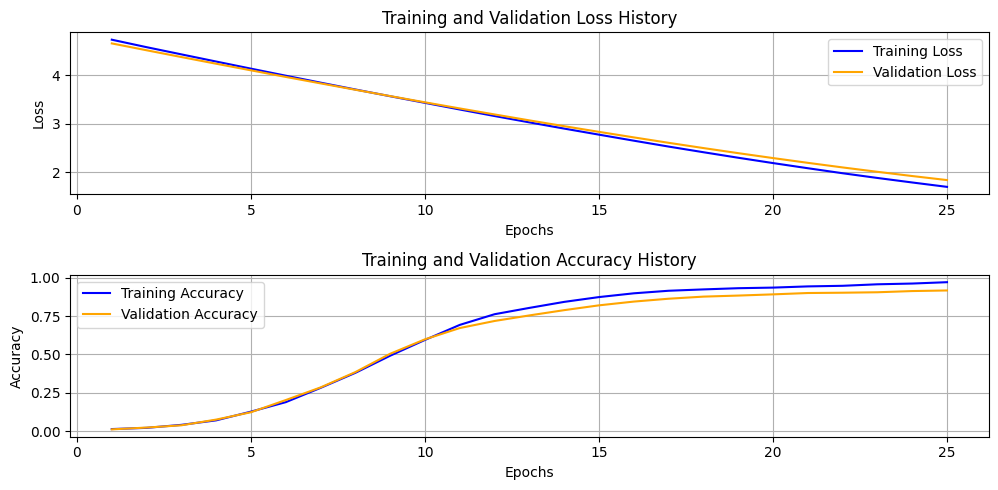

In [ ]:
# cell for plotting training and validation metrics
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# evaluate on test dataset
test_model(model, test_loader)

Test Accuracy: 91.19%


## Analysis of Results
### The training and validation loss graphs show a steady decline over the epochs, with both curves stabilizing towards the end, indicating effective learning. The accuracy graphs demonstrate a steady increase in both training and validation accuracy, with training accuracy slightly outperforming validation accuracy. The model achieved a test accuracy of 91.19%, suggesting strong performance on the test set.